In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
import numpy as np
import string
import re
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, DoubleType, LongType
from pyspark.sql import Row
import pickle
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stopwords.words('english'))

In [19]:
df = spark.read.csv(
    's3://aws-logs-816063959671-us-east-1/data/Reviews.csv',header=True)

In [20]:
df.cache()

DataFrame[Id: string, ProductId: string, UserId: string, ProfileName: string, HelpfulnessNumerator: string, HelpfulnessDenominator: string, Score: string, Time: string, Summary: string, Text: string]

In [21]:
df.count()

568454

In [22]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



## Count nulls

In [23]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                   0|                     0|    0|   0|      0|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [24]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                   0|                     0|    0|   0|      0|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



# EDA

### Cleaning Text

In [25]:
df.columns

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

#### Lowercase

In [26]:
for col in ['Summary', 'Text']:
    df = df.withColumn(col, F.lower(F.col(col)))

### Create text length columns

In [27]:
def word_length(string):
    tokens = word_tokenize(string)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    return len(tokens)

In [28]:
function = udf(word_length, LongType())
df = df.withColumn('Summary_len', function(df.Summary))
df = df.withColumn('Text_len', function(df.Text))

### Clean based on Text Length

In [29]:
df.select('Summary_len').describe().show()

+-------+------------------+
|summary|       Summary_len|
+-------+------------------+
|  count|            568454|
|   mean| 4.218930643464555|
| stddev|2.7689527586206704|
|    min|                 0|
|    max|                58|
+-------+------------------+



#### Count instances where the summary length is greater than text length to immediately filter out

In [30]:
df.filter(df.Summary_len >= df.Text_len).count()

1527

In [31]:
df = df.filter(df.Summary_len < df.Text_len)

#### Filter out summaries that are too long

In [32]:
df.filter(df.Summary_len > 20).count()

400

In [33]:
df = df.filter(df.Summary_len <= 20)

### Investigate short summaries

In [34]:
df.filter(df.Summary_len == 0).count()

96

In [35]:
df.select('Summary').filter(df.Summary_len == 0).show(5)

+--------------------+
|             Summary|
+--------------------+
|                  =]|
|                ????|
|$$$$$$$$$$$$$$$$$...|
|                 ???|
|                  $$|
+--------------------+
only showing top 5 rows



In [36]:
df.select('Summary').filter(df.Summary_len == 1).show(20)

+-------------+
|      Summary|
+-------------+
|    twizzlers|
|    twizzlers|
|       yummy!|
|   satisfying|
|   food-great|
|         good|
|        mushy|
|         good|
|   delicious!|
|        great|
|          bad|
|        tart!|
|disappointing|
|       jell-o|
|       tasty!|
|   delicious!|
|        handy|
|      miracle|
|      tasty!!|
|      altoids|
+-------------+
only showing top 20 rows



In [37]:
df.select('Summary').filter(df.Summary_len <= 1).count()

58434

In [38]:
df = df.filter(df.Summary_len > 0)

It looks like summaries with a word length of 1 make up 1/10 of the dataset. Thats a lot of data, this shouldn't be filtered out. Summaries with a word length of 0 seem to be made up of emojis or useless symbols and there are only 96 cases, so those will be removed, as well as summaries with > 20 words

### Investigating source Text length

In [39]:
df.cache()

DataFrame[Id: string, ProductId: string, UserId: string, ProfileName: string, HelpfulnessNumerator: string, HelpfulnessDenominator: string, Score: string, Time: string, Summary: string, Text: string, Summary_len: bigint, Text_len: bigint]

In [40]:
df.select('Text_len').describe().show()

+-------+-----------------+
|summary|         Text_len|
+-------+-----------------+
|  count|           566431|
|   mean|72.41091324450815|
| stddev|63.09016722600273|
|    min|                2|
|    max|             2239|
+-------+-----------------+



In [41]:
print('{} rows have a text length less than 20 words'.format(df.filter(df.Text_len <= 20).count()))
print('{}% of rows have a text length less than 20 words'.format(round(df.filter(df.Text_len <= 20).count()
                                                                       /df.count(),2)))

29404 rows have a text length less than 20 words
0.05% of rows have a text length less than 20 words


Many reviews have under 20 words. It's a tough decision to make, but these will be removed from the dataset

In [42]:
df = df.filter(df.Text_len > 20)

#### Filter out all rows where the summary isnt half the length of the review (or smaller)

In [43]:
df.filter(df.Text_len*0.5 <= df.Summary_len).count()

649

In [44]:
df = df.filter(df.Text_len*0.5 > df.Summary_len)

In [45]:
df.select('Text_len').describe().show()

+-------+-----------------+
|summary|         Text_len|
+-------+-----------------+
|  count|           536378|
|   mean|75.52767078440951|
| stddev|63.39854954180554|
|    min|               21|
|    max|             2239|
+-------+-----------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37270ced68>]],
      dtype=object)

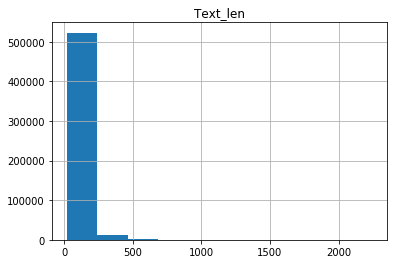

In [46]:
df.select('Text_len').toPandas().hist()

### Only include reviews with a word length <= 250 words

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37271f5860>]],
      dtype=object)

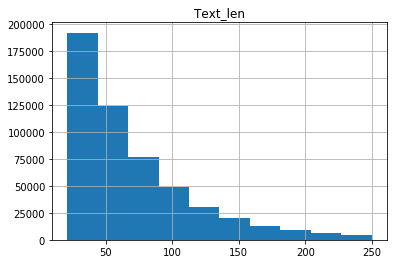

In [47]:
df.select('Text_len').filter(df.Text_len<=250).toPandas().hist()

In [48]:
df = df.filter(df.Text_len<=250)

# Clean text

We only want to clean the Reddit Post Content, not the summary, since we want the output of our model to be plain english.

In [49]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    
    if True:
        text = text.split()
        new_text = [CONTRACTIONS[w] if w in CONTRACTIONS else w for w in text]
        text = " ".join(new_text)
    
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    if remove_stopwords==True:
        tokens = [w for w in tokens if w not in STOPWORDS]
    return tokens

In [50]:
df.columns

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text',
 'Summary_len',
 'Text_len']

In [51]:
cleantext_udf = udf(clean_text, StringType())
df = df.withColumn('Summary_cleaned', 
                           cleantext_udf(df.Summary, F.lit(True)))

In [52]:
df.select('Summary').show()

+--------------------+
|             Summary|
+--------------------+
|good quality dog ...|
|   not as advertised|
|"""delight"" says...|
|      cough medicine|
|         great taffy|
|          nice taffy|
|great!  just as g...|
|wonderful, tasty ...|
|          yay barley|
|    healthy dog food|
|the best hot sauc...|
|"my cats love thi...|
|my cats are not f...|
|strawberry twizzl...|
|lots of twizzlers...|
|          poor taste|
|            love it!|
|  great sweet candy!|
|home delivered tw...|
|        always fresh|
+--------------------+
only showing top 20 rows



## Clean the ratings for sentiment analysis

In [53]:
df.select('Score').distinct().show()

+-----+
|Score|
+-----+
|    3|
|    0|
|    5|
|    1|
|    4|
|    2|
+-----+



Score is supposed to be a value 0-5, indicating a product rating. Need to clean this

In [54]:
df.filter(df.Score.isin(['1','2','3','4','5'])).select('Score').distinct().show()

+-----+
|Score|
+-----+
|    3|
|    5|
|    1|
|    4|
|    2|
+-----+



In [55]:
df.filter(df.Score.isin(['1','2','3','4','5'])).select('Score').count()

524319

Great, most of the dataset is still retained

In [56]:
df = df.filter(df.Score.isin(['1','2','3','4','5']))
df = df.withColumn("Score", df["Score"].cast(IntegerType()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37270bed68>]],
      dtype=object)

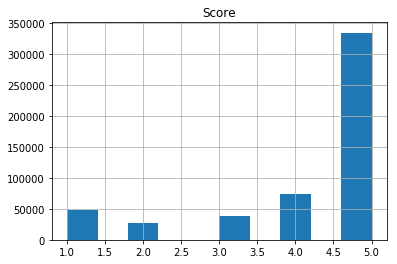

In [57]:
df.select('Score').toPandas().astype('int64').hist()

# The end goal is to create text summarization, and to perform sentiment analysis

In this case, ratings of 1 star (score=1) are considered negative sentiment, while ratings of 5 star are considered positive sentiment. As you can see in the histogram above, users are far more likely to give 5 star reviews. There are also a lack of 1 star reviews. We will create a subset for sentiment analysis and perform random undersampling on the 5 star reviews to create a balanced dataset, which will greatly help the performance of many common models used for sentiment analysis. We will keep the entire dataset to train the text summarization model

In [58]:
subset_1star = df.filter(df.Score == 1)
subset_5star = df.filter(df.Score == 5)
print('# 1 star reviews: {}'.format(subset_1star.count()))
print('# 5 star reviews: {}'.format(subset_5star.count()))


# 1 star reviews: 48723
# 5 star reviews: 334962


### Random undersampling the positive class (5 star reviews)

In [59]:
sample_ratio = subset_1star.count()/subset_5star.count()
subset_5star = subset_5star.sample(withReplacement=False, fraction=sample_ratio)

### Combine the positive and negative classes into one dataframe

In [60]:
subset = subset_1star.union(subset_5star)

In [61]:
len(subset.randomSplit([0.9,0.1]))

2

# Created a function in src/util.py to retrace what was done in this notebook

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
import numpy as np
import string
import re
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, DoubleType, LongType
from pyspark.sql import Row
import pickle
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stopwords.words('english'))
from pyspark.sql import SparkSession


def word_length(string):
    tokens = word_tokenize(string)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    return len(tokens)

def clean_text(text, remove_stopwords=True):
    text = text.lower()
    
    if True:
        text = text.split()
        new_text = [CONTRACTIONS[w] if w in CONTRACTIONS else w for w in text]
        text = " ".join(new_text)
    
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    if remove_stopwords==True:
        tokens = [w for w in tokens if w not in STOPWORDS]
    return tokens

def clean_df(df, output_csv=False):

    # Lowercase reviews and summaries
    for col in ['Summary', 'Text']:
        df = df.withColumn(col, F.lower(F.col(col)))
    # Create word_length columns    
    function = udf(word_length, LongType())
    df = df.withColumn('Summary_len', function(df.Summary))
    df = df.withColumn('Text_len', function(df.Text))    
    # Filter rows by word lengths
    df = df.filter(df.Summary_len <= 20)
    df = df.filter(df.Text_len > 20)
    df = df.filter(df.Text_len*0.5 > df.Summary_len)
    df = df.filter(df.Text_len<=250)
    # Clean text
    cleantext_udf = udf(clean_text, StringType())
    df = df.withColumn('Summary_cleaned', 
            cleantext_udf(df.Summary, F.lit(True)))
    # Clean reviews
    df = df.filter(df.Score.isin(['1','2','3','4','5']))
    df = df.withColumn("Score", df["Score"].cast(IntegerType()))
    if output_csv==True:
        subset = df.select('Text', 'Summary')
        train, test = subset.randomSplit([0.9,0.1])
        X_train, y_train = train.select('Text'), train.select('Summary')
        X_test, y_test = test.select('Text'), test.select('Summary')
        X_train.write.csv('sumdata/train/train.article.csv', mode='append')
        y_train.write.csv('sumdata/train/train.title.csv', mode='append')
        X_test.write.csv('sumdata/train/valid.article.filter.csv', mode='append')
        y_test.write.csv('sumdata/train/talid.title.filter.csv', mode='append')
        
        #df.write.save(path='csv', format='csv', mode='append', sep='\t')
    return df

def sentiment_subset(df):
    subset_1star = df.filter(df.Score == 1)
    subset_5star = df.filter(df.Score == 5)
    # Random undersampling
    sample_ratio = subset_1star.count()/subset_5star.count()
    subset_5star = subset_5star.sample(withReplacement=False, fraction=sample_ratio)
    subset = subset_1star.union(subset_5star)
    return subset

# if __name__ == "__main__":
#     spark = SparkSession.builder.appName("CleaningApp").getOrCreate()
#     df = spark.read.csv(
#     's3n://aws-logs-816063959671-us-east-1/data/Reviews.csv',header=True)
#     df.cache()
#     clean_df(df, output_csv=True)


In [64]:
df = spark.read.csv(
    's3n://aws-logs-816063959671-us-east-1/data/Reviews.csv',header=True)

In [ ]:
df = clean_df(df, output_csv=True)